# TensorTrade - Renderers and Visualization Chart

## Setup Data Fetching

In [1]:
import pandas as pd

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)
    df.set_index("date", inplace=True)
    return df

In [2]:
df = load_csv('Coinbase_BTCUSD_1h.csv')
df.head(3)

,open,high,low,close,volume
date,,,,,
2019-10-17 09-AM,8051.00,8056.83,8021.23,8035.88,492394.56
2019-10-17 08-AM,7975.89,8070.00,7975.89,8051.00,2971610.86
2019-10-17 07-AM,7964.62,7987.82,7964.61,7975.89,970521.83


## Data Preparation
### Create the dataset features

In [4]:
import ta

from tensortrade.data import DataFeed, Module

dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
dataset.head(3)

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
date,,,,,,,,,,,,,,,,,,,,,
2019-10-17 09-AM,8051.00,8056.83,8021.23,8035.88,492394.56,-8.713724e+04,492394.56,-0.176966,0.000000e+00,0.000000,...,50.0,41.151685,41.151685,-58.848315,0.0,8035.88,0.0,11.938592,0.000000,0.000000
2019-10-17 08-AM,7975.89,8070.00,7975.89,8051.00,2971610.86,1.684588e+06,3464005.42,0.486312,4.493076e+07,-50940.699214,...,50.0,79.810860,60.481273,-20.189140,0.0,8051.00,0.0,0.188156,0.187979,0.188156
2019-10-17 07-AM,7964.62,7987.82,7964.61,7975.89,970521.83,1.657409e+06,2493483.59,0.373751,2.809838e+07,-111754.652649,...,50.0,10.703103,43.888549,-89.296897,0.0,7975.89,0.0,-0.932928,-0.937307,-0.746527


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [5]:
price_history = dataset[['open', 'high', 'low', 'close', 'volume']]
price_history.reset_index(inplace=True)  # the index will be used as the chart training steps
display(price_history.head(3))

dataset.drop(columns=['open', 'high', 'low', 'close', 'volume'], inplace=True)

,date,open,high,low,close,volume
0,2019-10-17 09-AM,8051.00,8056.83,8021.23,8035.88,492394.56
1,2019-10-17 08-AM,7975.89,8070.00,7975.89,8051.00,2971610.86
2,2019-10-17 07-AM,7964.62,7987.82,7964.61,7975.89,970521.83


## Setup Trading Environment
### Create Data Feeds

In [6]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, DataFeed, Module
from tensortrade.instruments import USD, BTC
from tensortrade.wallets import Wallet, Portfolio

coinbase = Exchange("coinbase", service=execute_order)(
    Stream("USD-BTC", price_history['close'].tolist())
)

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 10 * BTC),
])

with Module("coinbase") as coinbase_ns:
    nodes = [Stream(name, dataset[name].tolist()) for name in dataset.columns]

feed = DataFeed([coinbase_ns])
display(feed.next())

{'coinbase:/volume_adi': -87137.23955055085,
 'coinbase:/volume_obv': 492394.56,
 'coinbase:/volume_cmf': -0.17696629213480922,
 'coinbase:/volume_fi': 0.0,
 'coinbase:/volume_em': 0.0,
 'coinbase:/volume_sma_em': 0.0,
 'coinbase:/volume_vpt': 57684.90807817994,
 'coinbase:/volume_nvi': 1000.0,
 'coinbase:/volatility_atr': 0.0,
 'coinbase:/volatility_bbm': 8035.88,
 'coinbase:/volatility_bbh': 8035.88,
 'coinbase:/volatility_bbl': 8035.88,
 'coinbase:/volatility_bbw': 0.0,
 'coinbase:/volatility_bbhi': 0.0,
 'coinbase:/volatility_bbli': 0.0,
 'coinbase:/volatility_kcc': 8037.98,
 'coinbase:/volatility_kch': 8037.98,
 'coinbase:/volatility_kcl': 8002.38,
 'coinbase:/volatility_kchi': 0.0,
 'coinbase:/volatility_kcli': 0.0,
 'coinbase:/volatility_dcl': 8035.88,
 'coinbase:/volatility_dch': 8035.88,
 'coinbase:/volatility_dchi': 1.0,
 'coinbase:/volatility_dcli': 1.0,
 'coinbase:/trend_macd': 0.0,
 'coinbase:/trend_macd_signal': 0.0,
 'coinbase:/trend_macd_diff': 0.0,
 'coinbase:/trend_em

### Trading Environment Renderers
A renderer is a channel for a trading environement to output its current state. One or more renderers can be attached to the environement at the same time. The environment will use all the available renderers. Notice that not all renderers play well together so you need to choose the best combination for your situation. For example, PlotlyTradingChart can go well with FileLogger but not with ScreenLogger.
### Trading Environment with a Single Renderer

In [7]:
from tensortrade.environments.render import ScreenLogger
from tensortrade.environments import TradingEnvironment

env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20,
    price_history=price_history,
    renderer = [ScreenLogger()]  # used with default settings
)

In [8]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)
agent.train(n_episodes=2, n_steps=200, render_interval=10)

====      AGENT ID: 5551971d-c0b6-4e99-bd2a-61935f6388e1      ====
[2020-02-14 01:26:46] Episode: 1/2 - Step: 130/200
[2020-02-14 01:26:48] Episode: 1/2 - Step: 140/200
[2020-02-14 01:26:50] Episode: 1/2 - Step: 150/200
[2020-02-14 01:26:52] Episode: 1/2 - Step: 160/200
[2020-02-14 01:26:53] Episode: 1/2 - Step: 170/200
[2020-02-14 01:26:55] Episode: 1/2 - Step: 180/200
[2020-02-14 01:26:57] Episode: 1/2 - Step: 190/200
[2020-02-14 01:26:59] Episode: 1/2 - Step: 200/200
[2020-02-14 01:26:59] Episode: 1/2 - Step: 200/200
[2020-02-14 01:27:01] Episode: 2/2 - Step: 10/200
[2020-02-14 01:27:03] Episode: 2/2 - Step: 20/200
[2020-02-14 01:27:05] Episode: 2/2 - Step: 30/200
[2020-02-14 01:27:07] Episode: 2/2 - Step: 40/200
[2020-02-14 01:27:09] Episode: 2/2 - Step: 50/200
[2020-02-14 01:27:11] Episode: 2/2 - Step: 60/200
[2020-02-14 01:27:13] Episode: 2/2 - Step: 70/200
[2020-02-14 01:27:15] Episode: 2/2 - Step: 80/200
[2020-02-14 01:27:17] Episode: 2/2 - Step: 90/200
[2020-02-14 01:27:19] Ep

-0.1868766114101695

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

In [9]:
from tensortrade.environments.render import PlotlyTradingChart
from tensortrade.environments.render import FileLogger

chart_renderer = PlotlyTradingChart(
    height = 800
)

file_logger = FileLogger(
    filename='example.log',  # omit or None for automatic file name
    path='training_logs'  # create a new directory if doesn't exist, None for no directory
)

### Environement with Multiple Renderers

In [10]:
env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20,
    price_history=price_history,
    renderer = [chart_renderer, file_logger]
)

## Setup and Train DQN Agent

In [11]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)
agent.train(n_episodes=2, n_steps=200, render_interval=10)  # adjust interval to your computer performance

FigureWidget({
    'data': [{'close': array([8035.88, 8051.  , 7975.89, 7964.62, 7984.02, 7941.71, 7970.19, 79…

-0.14366231046550726

## Direct Performance and Net Worth Plotting
Alternatively, the final performance and net worth can be displayed using pandas via matplotlib.

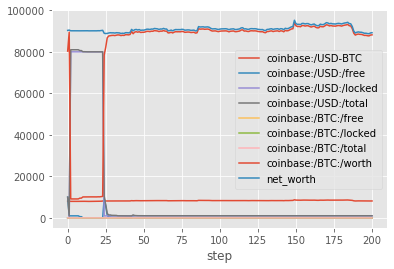

In [12]:
%matplotlib inline

portfolio.performance.plot()

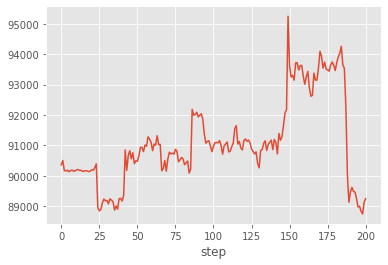

In [13]:
portfolio.performance.net_worth.plot()